In [1]:
import pandas as pd
import numpy as np
import os
import random
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, roc_auc_score, average_precision_score
import gc
from tqdm import tqdm
import time
from collections import defaultdict
import copy
import matplotlib.pyplot as plt

import torch
from torch.utils.data import Dataset
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.utils.data import DataLoader, Dataset
from torch.cuda.amp import autocast, GradScaler

import pdb


# Defining global parameters

In [2]:
def get_available_device():
    if torch.cuda.is_available():
        return "cuda"
    elif torch.backends.mps.is_available():
        return "mps"
    else:
        return "cpu"
    
CONFIG = {
    "seed": 42,
    "epochs": 12, # 42, ~MAX 20 hours of training
    "train_batch_size": 16,
    "valid_batch_size": 64,
    "learning_rate": 5e-5,
    "scheduler": 'CosineAnnealingLR',
    "min_lr": 5e-7,
    "T_max": 12,
    "weight_decay": 1e-6,
    "fold" : 0,
    "n_fold": 5,
    "n_accumulate": 1,
    "device": get_available_device(),
}

def seed_everything(seed=42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

seed_everything(seed=CONFIG['seed'])

# Read and split the data
## Validation set of 10% of the size

In [3]:
df = pd.read_pickle('enveda_chemist_preprocessed.pkl')
df.head()

ground_truth_smiles  \
7   CC1(C)C=Cc2c(ccc3c2[N+]([O-])=C2C(C)(C)C4CC56C...   
8   CC1(C)C=Cc2c(ccc3c2[N+]([O-])=C2C(C)(C)C4CC56C...   
9   CC1(C)C=Cc2c(ccc3c2[N+]([O-])=C2C(C)(C)C4CC56C...   
10  CC1(C)C=Cc2c(ccc3c2[N+]([O-])=C2C(C)(C)C4CC56C...   
11  CC1(C)C=Cc2c(ccc3c2[N+]([O-])=C2C(C)(C)C4CC56C...   

                                     predicted_smiles ground_truth_inchikey14  \
7   CC7(C)C=Cc1c(ccc2c1N=C6C2(O)CC45N=C(O)C3(CCCN3...          WZHCMAFZIFECCV   
8   CC7(C)C=Cc1c(ccc2c1N=C6C2(O)CC45N=C(O)C3(CCCN3...          WZHCMAFZIFECCV   
9   CC7(C)C=Cc1c(ccc2c1N=C6C2(O)CC45N=C(O)C3(CCCN3...          WZHCMAFZIFECCV   
10  CC7(C)C=Cc1c(ccc2c1N=C6C2(O)CC45N=C(O)C3(CCCN3...          WZHCMAFZIFECCV   
11  CC7(C)C=Cc1c(ccc2c1N=C6C2(O)CC45N=C(O)C3(CCCN3...          WZHCMAFZIFECCV   

   predicted_inchikey14 ground_truth_formula predicted_formula  \
7        PYHKDROAWLAEDE           C52H54N6O7        C26H29N3O4   
8        PYHKDROAWLAEDE           C52H54N6O7        C26H29N3O4   
9        PYHKDROAWLAEDE           C52H54N6O7        C26H29N3O4   
10       PYHKDROAWLAEDE           C52H54N6O7        C26H29N3O4   
11       PYHKDROAWLAEDE           C52H54N6O7        C26H29N3O4   

    annotator_name  unable_to_assess  not_close_match  close_match  \
7                0                 1                0            0   
8                1                 1                0            0   
9                2                 1                0            0   
10               3                 0                1            0   
11               4                 1                0            0   

    near_exact_match  exact_match  good_enough_for_prioritization  \
7                  0            0                               0   
8                  0            0                               0   
9                  0            0                               0   
10                 0            0                               0   
11                 0            0                               0   

    scaffold_correct  ground_truth_unable_to_annotate  \
7                  0                                1   
8                  0                                1   
9                  0                                1   
10                 1                                0   
11                 0                                1   

    ground_truth_has_scaffold ground_truth_scaffold_smiles  \
7                           1                         None   
8                           1                         None   
9                           1                         None   
10                          1    c1cc2c(c3C=CCOc3cc2)[nH]1   
11                          1                         None   

                         ground_truth_scaffold_smarts  \
7                                                None   
8                                                None   
9                                                None   
10  [#6]1:[#6]:[#6]2:[#6](:[#6]3-[#6]=[#6]-[#6]-[#...   
11                                               None   

                              ground_truth_embeddings  \
7   [[0.5249032, 0.25463393, 1.1345547, 0.90460753...   
8   [[0.5249032, 0.25463393, 1.1345547, 0.90460753...   
9   [[0.5249032, 0.25463393, 1.1345547, 0.90460753...   
10  [[0.5249032, 0.25463393, 1.1345547, 0.90460753...   
11  [[0.5249032, 0.25463393, 1.1345547, 0.90460753...   

                                 predicted_embeddings  
7   [[0.96212196, 0.038500108, 0.9624641, 0.423108...  
8   [[0.96212196, 0.038500108, 0.9624641, 0.423108...  
9   [[0.96212196, 0.038500108, 0.9624641, 0.423108...  
10  [[0.96212196, 0.038500108, 0.9624641, 0.423108...  
11  [[0.96212196, 0.038500108, 0.9624641, 0.423108...

In [4]:
train_df, valid_df = train_test_split(df, test_size=0.1)

## Wrapping in Pytorch Dataset

In [5]:
class EnvedaDataset(Dataset):
    def __init__(self, dataframe, labels = ['unable_to_assess', 'close_match', 
                                            'near_exact_match', 'exact_match']):
        """
        Args:
            dataframe (pd.DataFrame): A DataFrame containing 'ground_truth_embeddings', 
                                       'predicted_embeddings', and output columns.
        """
        self.dataframe = dataframe
        
        # Convert embeddings to tensors
        self.ground_truth_embeddings = torch.tensor(dataframe['ground_truth_embeddings'].tolist(), dtype=torch.float32)
        self.predicted_embeddings = torch.tensor(dataframe['predicted_embeddings'].tolist(), dtype=torch.float32)
        
        # Convert labels to tensor
        self.labels = torch.tensor(dataframe[labels].values, dtype=torch.float32)

    def __len__(self):
        """Returns the total number of samples."""
        return len(self.dataframe)

    def __getitem__(self, idx):
        """Generates one sample of data."""
        return self.ground_truth_embeddings[idx].squeeze(0), self.predicted_embeddings[idx].squeeze(0), self.labels[idx]


In [6]:
trainset = EnvedaDataset(dataframe=train_df)
validset = EnvedaDataset(dataframe=valid_df)

/var/folders/5g/t9d5_kvd3kb4yljp4f0pvqqc0000gn/T/ipykernel_4405/1071876538.py:12: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/utils/tensor_new.cpp:264.)
  self.ground_truth_embeddings = torch.tensor(dataframe['ground_truth_embeddings'].tolist(), dtype=torch.float32)


In [7]:
trainset[0]

(tensor([ 5.0838e-01,  8.4420e-01,  3.7037e-01,  1.9899e-01, -2.8897e-01,
         -8.3254e-01,  4.8153e-01, -3.1924e-02,  5.0763e-01, -4.7314e-01,
         -1.7510e-01,  7.7394e-01, -2.4241e-01, -1.2277e-01,  7.5280e-01,
          3.1169e-02, -3.9296e-01,  4.9238e-01,  1.4855e-01,  3.0073e-01,
         -6.9042e-01, -4.9700e-01,  2.8186e-01,  1.1053e+00, -5.0993e-01,
          1.4283e-01, -1.3863e+00, -1.8055e-01, -5.4832e-01,  4.5106e-01,
         -8.6256e-02,  2.0357e-01, -3.4630e-01,  2.9551e-01,  3.4969e-01,
         -1.6433e-01, -3.9057e-02, -1.6552e-01, -1.5440e+00,  1.4740e-01,
          3.8093e-01,  3.7583e-01,  8.5357e-02, -7.7270e-02, -2.9127e-01,
         -2.4007e-01,  6.4164e-01,  7.8616e-01,  4.0936e-01, -3.7114e-01,
          3.7692e-01,  2.5409e-01,  1.0260e-01,  2.8552e-01,  8.1997e-02,
          1.9414e-01,  1.5973e-01, -2.2403e-01, -5.9994e-01,  1.6873e-01,
          3.6277e-01,  1.3814e-01, -1.0932e+00, -5.2755e-01,  5.9447e-01,
         -4.5042e-02,  1.0199e-01, -1.

## Wrapping in Pytorch DataLoader

In [8]:
trainloader, validloader = DataLoader(trainset, batch_size=CONFIG['train_batch_size']), \
                           DataLoader(validset, batch_size=CONFIG['valid_batch_size'])

In [9]:
gt, pred, labels = next(iter(trainloader))
print(gt.shape, pred.shape, labels.shape)


torch.Size([16, 768]) torch.Size([16, 768]) torch.Size([16, 4])


# Defining neural network

In [17]:
# Define the Siamese Network
class SiameseNetwork(nn.Module):
    def __init__(self, input_dim=768, output_dim=4):
        super(SiameseNetwork, self).__init__()
        self.fc1 = nn.Linear(input_dim, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 32)
        self.fc4 = nn.Linear(32, 16)
        self.fc5 = nn.Linear(16 * 2, output_dim)  # Output layer for similarity judgements

    def forward_one(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.relu(self.fc3(x))
        x = torch.relu(self.fc4(x))
        return x

    def forward(self, input1, input2):
        out1 = self.forward_one(input1)
        out2 = self.forward_one(input2)
        # pdb.set_trace()
        # Combine both outputs by concatenation
        combined = torch.concat((out1, out2), dim=1) # concatenate embeddings
        output = self.fc5(combined)                  # Outputs raw logits
        return output
    
# model = SiameseNetwork()
# model(gt, pred)

# Training and validation regime

## Training with mixed precision, gradient accumulation, learning with scheduler
## Validation logging loss, AUROC, and F1 metrics

In [19]:
def train_one_epoch(model, optimizer, criterion, scheduler, dataloader, epoch=CONFIG['epochs']):
    model.train()
    
    scaler = GradScaler()
    dataset_size = 0
    running_loss = 0.0
    running_auroc  = 0.0
    running_f1 = 0.0
    bar = tqdm(enumerate(dataloader), total=len(dataloader))
    for step, data in bar:
        
        gt, preds, targets = data
        gt, preds, targets = gt.to(CONFIG['device']), preds.to(CONFIG['device']), targets.to(CONFIG['device'])
        batch_size = gt.shape[0]

        with autocast():
            outputs = model(gt, preds)
            loss = criterion(outputs, targets)
            loss = loss / CONFIG['n_accumulate']
            
        # Backward pass with scaling
        scaler.scale(loss).backward()
    
        if (step + 1) % CONFIG['n_accumulate'] == 0:
            # Step the optimizer
            scaler.step(optimizer)

            # Update the scale for next iteration
            scaler.update()
            # optimizer.step()

            # zero the parameter gradients
            optimizer.zero_grad()

            if scheduler is not None:
                scheduler.step()
        
        # pdb.set_trace()
        probabilities = torch.softmax(outputs, dim=1).detach().cpu().numpy() if outputs.shape[1] > 1 else torch.sigmoid(outputs).detach().cpu().numpy()
        preds = np.eye(outputs.shape[1])[np.argmax(probabilities, axis=1)] if outputs.shape[1] > 1 else (probabilities > 0.5).float()
        # pdb.set_trace()
        auroc = average_precision_score(targets.cpu().numpy(), probabilities)
        f1 = f1_score(targets.cpu().numpy(), preds, average='weighted')
        
        running_loss += (loss.item() * batch_size)
        running_auroc  += (auroc * batch_size)
        running_f1 += (f1 * batch_size)
        dataset_size += batch_size
        
        epoch_loss = running_loss / dataset_size
        epoch_auroc = running_auroc / dataset_size
        epoch_f1 = running_f1 / dataset_size
        
        bar.set_postfix(Epoch=epoch, Train_Loss=epoch_loss, Train_Auroc=epoch_auroc, Train_F1=epoch_f1,
                        LR=optimizer.param_groups[0]['lr'])
    gc.collect()
    
    return epoch_loss, epoch_auroc, epoch_f1

@torch.no_grad()
def valid_one_epoch(model, dataloader, criterion, epoch):
    model.eval()
    
    dataset_size = 0
    running_loss = 0.0
    running_auroc = 0.0
    running_f1 = 0.0 
    
    bar = tqdm(enumerate(dataloader), total=len(dataloader))
    for step, data in bar:
        
        gt, preds, targets = data
        gt, preds, targets = gt.to(CONFIG['device']), preds.to(CONFIG['device']), targets.to(CONFIG['device'])
        batch_size = gt.shape[0]
        
        with autocast():
            outputs = model(gt, preds)
            loss = criterion(outputs, targets)
            loss = loss / CONFIG['n_accumulate']
        
        probabilities = torch.softmax(outputs, dim=1).detach().cpu().numpy() if outputs.shape[1] > 1 else torch.sigmoid(outputs).detach().cpu().numpy()
        preds = np.eye(outputs.shape[1])[np.argmax(probabilities, axis=1)] if outputs.shape[1] > 1 else (probabilities > 0.5).float()
        
        auroc = average_precision_score(targets.cpu().numpy(), probabilities)
        f1 = f1_score(targets.cpu().numpy(), preds, average='weighted')
        
        running_loss += (loss.item() * batch_size)
        running_auroc  += (auroc * batch_size)
        running_f1 += (f1 * batch_size)
        dataset_size += batch_size
        
        epoch_loss = running_loss / dataset_size
        epoch_auroc = running_auroc / dataset_size
        epoch_f1 = running_f1 / dataset_size
        
        bar.set_postfix(Epoch=epoch, Valid_Loss=epoch_loss, Valid_Auroc=epoch_auroc, 
                        Valid_F1=epoch_f1,
                        )   
    gc.collect()
    
    return epoch_loss, epoch_auroc, epoch_f1

## Initializing components
1. Model
2. AdamW optimizer
3. Cosine annealing scheduler
4. Weighted cross entropy loss to handle class imbalance

In [20]:
model = SiameseNetwork().to(CONFIG['device'])
optimizer = optim.AdamW(model.parameters(), lr=CONFIG['learning_rate'], 
                       weight_decay=CONFIG['weight_decay'])
scheduler = lr_scheduler.CosineAnnealingLR(optimizer,T_max=CONFIG['T_max'], 
                                                   eta_min=CONFIG['min_lr'])
print(df[['unable_to_assess','close_match', 'near_exact_match','exact_match']].sum())
class_distribution = {'unable_to_assess': 73, 
                      'close_match': 605, 
                      'near_exact_match': 360, 
                      'exact_match': 73}

# Calculate class weights
total_samples = sum(class_distribution.values())
class_weights = {label: total_samples / (len(class_distribution) * count) for label, count in class_distribution.items()}

# Convert weights to a tensor
weights = torch.tensor([class_weights['unable_to_assess'],
                        class_weights['close_match'],
                        class_weights['near_exact_match'],
                        class_weights['exact_match']], dtype=torch.float32).to(CONFIG['device'])

# Modify the loss function in your training loop
criterion = nn.CrossEntropyLoss(weight=weights)



unable_to_assess     73
close_match         605
near_exact_match    360
exact_match          73
dtype: int64


In [21]:
# train_one_epoch(model=model, optimizer=optimizer, criterion=criterion, scheduler=scheduler, dataloader=trainloader)
# valid_one_epoch(model=model, dataloader=trainloader, criterion=criterion, epoch=CONFIG['epochs'])

## Putting all together into training code
Training code includes:
1. Early stopping
2. Saving best model weights according to supplied name
3. Original code adapted from Kaggle

In [22]:

def run_training(model, optimizer, scheduler, criterion, num_epochs, train_loader, valid_loader, name):
    if torch.cuda.is_available():
        print("[INFO] Using GPU: {}\n".format(torch.cuda.get_device_name()))
    
    start = time.time()
    best_model_wts = copy.deepcopy(model.state_dict())
    best_epoch_f1 = -np.inf
    best_valid_loss = np.inf
    history = defaultdict(list)
    
    for epoch in range(1, num_epochs + 1): 
        gc.collect()
        train_epoch_loss, train_epoch_auroc, train_epoch_f1 = train_one_epoch(model=model, optimizer=optimizer, scheduler=scheduler, 
                                           criterion=criterion, dataloader=train_loader, 
                                           epoch=epoch)
        
        val_epoch_loss, val_epoch_auroc, val_epoch_f1 = valid_one_epoch(model=model, dataloader=valid_loader, criterion=criterion, 
                                         epoch=epoch)
    
        history['Train Loss'].append(train_epoch_loss)
        history['Valid Loss'].append(val_epoch_loss)
        history['Train AUROC'].append(train_epoch_auroc)
        history['Valid AUROC'].append(val_epoch_auroc)
        history['Valid F1'].append(val_epoch_f1)
        history['lr'].append( scheduler.get_lr()[0] )
        if val_epoch_loss <= best_valid_loss:
            print(f"Validation Loss Improved ({best_valid_loss} ---> {val_epoch_loss})")
            best_valid_loss = val_epoch_loss
            best_model_wts = copy.deepcopy(model.state_dict())
            PATH = f"best_VAL_LOSS_model_{name}.bin"
            torch.save(model.state_dict(), PATH)
            # Save a model file from the current directory
            print(f"Model Saved")
        
        if best_epoch_f1 <= val_epoch_f1:
            print(f"Validation F1 Improved ({best_epoch_f1} ---> {val_epoch_f1})")
            best_epoch_f1 = val_epoch_f1
            best_model_wts = copy.deepcopy(model.state_dict())
            PATH = f"best_F1_model_{name}.bin"
            torch.save(model.state_dict(), PATH)
            # Save a model file from the current directory
            print(f"Model Saved")
            
        print()
    
    end = time.time()
    time_elapsed = end - start
    print('Training complete in {:.0f}h {:.0f}m {:.0f}s'.format(
        time_elapsed // 3600, (time_elapsed % 3600) // 60, (time_elapsed % 3600) % 60))
    print("Best F1: {:.4f}".format(best_epoch_f1))
    print("Best Loss: {:.4f}".format(best_valid_loss))
    
    # load best model weights
    model.load_state_dict(best_model_wts)
    
    return model, history

In [24]:
model, history = run_training(model=model, optimizer=optimizer, 
                              scheduler=scheduler, criterion=criterion, 
                              num_epochs=100, train_loader=trainloader, valid_loader=validloader, 
                              name='siamese_multiclass')

/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/torch/cuda/amp/grad_scaler.py:125: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(
  0%|          | 0/94 [00:00<?, ?it/s]/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:980: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
  0%|          | 0/94 [00:00<?, ?it/s, Epoch=1, LR=4.92e-5, Train_Auroc=0.25, Train_F1=0.151, Train_Loss=0.954]/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:980: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site

Validation Loss Improved (inf ---> 0.7818353375988806)
Model Saved
Validation F1 Improved (-inf ---> 0.13923189933892985)
Model Saved



  0%|          | 0/94 [00:00<?, ?it/s]/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:980: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
  0%|          | 0/94 [00:00<?, ?it/s, Epoch=2, LR=4.28e-5, Train_Auroc=0.243, Train_F1=0.114, Train_Loss=0.946]/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:980: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-pack

Validation Loss Improved (0.7818353375988806 ---> 0.7780547880840872)
Model Saved



  0%|          | 0/94 [00:00<?, ?it/s]/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:980: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
  0%|          | 0/94 [00:00<?, ?it/s, Epoch=3, LR=3.17e-5, Train_Auroc=0.243, Train_F1=0.114, Train_Loss=0.945]/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:980: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-pack

Validation Loss Improved (0.7780547880840872 ---> 0.7735627911048021)
Model Saved



  0%|          | 0/94 [00:00<?, ?it/s]/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:980: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
  0%|          | 0/94 [00:00<?, ?it/s, Epoch=4, LR=1.88e-5, Train_Auroc=0.245, Train_F1=0.114, Train_Loss=0.943]/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:980: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-pack

Validation Loss Improved (0.7735627911048021 ---> 0.7681154462391745)
Model Saved
Validation F1 Improved (0.13923189933892985 ---> 0.1429009269337574)
Model Saved



  0%|          | 0/94 [00:00<?, ?it/s]/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:980: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
  0%|          | 0/94 [00:00<?, ?it/s, Epoch=5, LR=7.75e-6, Train_Auroc=0.247, Train_F1=0.114, Train_Loss=0.941]/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:980: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-pack

Validation Loss Improved (0.7681154462391745 ---> 0.7631063197187321)
Model Saved
Validation F1 Improved (0.1429009269337574 ---> 0.14439551454631336)
Model Saved



  0%|          | 0/94 [00:00<?, ?it/s]/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:980: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
  0%|          | 0/94 [00:00<?, ?it/s, Epoch=6, LR=1.34e-6, Train_Auroc=0.255, Train_F1=0.0989, Train_Loss=0.938]/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:980: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-pac

Validation Loss Improved (0.7631063197187321 ---> 0.7572008267848077)
Model Saved



  0%|          | 0/94 [00:00<?, ?it/s]/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:980: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
  0%|          | 0/94 [00:00<?, ?it/s, Epoch=7, LR=1.34e-6, Train_Auroc=0.262, Train_F1=0.0989, Train_Loss=0.934]/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:980: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-pac

Validation Loss Improved (0.7572008267848077 ---> 0.7519692125434647)
Model Saved



  0%|          | 0/94 [00:00<?, ?it/s]/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:980: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
  0%|          | 0/94 [00:00<?, ?it/s, Epoch=8, LR=7.75e-6, Train_Auroc=0.262, Train_F1=0.0989, Train_Loss=0.93]/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:980: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-pack

Validation Loss Improved (0.7519692125434647 ---> 0.7479001012390959)
Model Saved



  0%|          | 0/94 [00:00<?, ?it/s]/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:980: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
  0%|          | 0/94 [00:00<?, ?it/s, Epoch=9, LR=1.88e-5, Train_Auroc=0.263, Train_F1=0.071, Train_Loss=0.926]/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:980: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-pack

Validation Loss Improved (0.7479001012390959 ---> 0.7432999261125119)
Model Saved
Validation F1 Improved (0.14439551454631336 ---> 0.1584431911821377)
Model Saved



  0%|          | 0/94 [00:00<?, ?it/s]/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:980: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
  0%|          | 0/94 [00:00<?, ?it/s, Epoch=10, LR=3.17e-5, Train_Auroc=0.262, Train_F1=0.071, Train_Loss=0.923]/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:980: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-pac

Validation Loss Improved (0.7432999261125119 ---> 0.7385444469794542)
Model Saved



  0%|          | 0/94 [00:00<?, ?it/s]/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:980: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
  0%|          | 0/94 [00:00<?, ?it/s, Epoch=11, LR=4.28e-5, Train_Auroc=0.262, Train_F1=0.071, Train_Loss=0.919]/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:980: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-pac

Validation Loss Improved (0.7385444469794542 ---> 0.7336193426640448)
Model Saved
Validation F1 Improved (0.1584431911821377 ---> 0.20170546565964695)
Model Saved



  0%|          | 0/94 [00:00<?, ?it/s]/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:980: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
  0%|          | 0/94 [00:00<?, ?it/s, Epoch=12, LR=4.92e-5, Train_Auroc=0.262, Train_F1=0.071, Train_Loss=0.915]/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:980: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-pac

Validation Loss Improved (0.7336193426640448 ---> 0.7283156000211567)
Model Saved
Validation F1 Improved (0.20170546565964695 ---> 0.2559160412432554)
Model Saved



  0%|          | 0/94 [00:00<?, ?it/s]/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:980: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
  0%|          | 0/94 [00:00<?, ?it/s, Epoch=13, LR=4.92e-5, Train_Auroc=0.262, Train_F1=0.0659, Train_Loss=0.91]/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:980: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-pac

Validation Loss Improved (0.7283156000211567 ---> 0.7230046859044514)
Model Saved
Validation F1 Improved (0.2559160412432554 ---> 0.26841605799313173)
Model Saved



  0%|          | 0/94 [00:00<?, ?it/s]/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:980: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
  0%|          | 0/94 [00:00<?, ?it/s, Epoch=14, LR=4.28e-5, Train_Auroc=0.261, Train_F1=0.0659, Train_Loss=0.906]/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:980: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-pa

Validation Loss Improved (0.7230046859044514 ---> 0.7172016733420823)
Model Saved



  0%|          | 0/94 [00:00<?, ?it/s]/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:980: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
  0%|          | 0/94 [00:00<?, ?it/s, Epoch=15, LR=3.17e-5, Train_Auroc=0.262, Train_F1=0.071, Train_Loss=0.902]/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:980: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-pac

Validation Loss Improved (0.7172016733420823 ---> 0.7116290577157529)
Model Saved



  0%|          | 0/94 [00:00<?, ?it/s]/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:980: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
  0%|          | 0/94 [00:00<?, ?it/s, Epoch=16, LR=1.88e-5, Train_Auroc=0.265, Train_F1=0.071, Train_Loss=0.898]/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:980: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-pac

Validation Loss Improved (0.7116290577157529 ---> 0.7066880325357358)
Model Saved
Validation F1 Improved (0.26841605799313173 ---> 0.2719483716505235)
Model Saved



  0%|          | 0/94 [00:00<?, ?it/s]/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:980: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
  0%|          | 0/94 [00:00<?, ?it/s, Epoch=17, LR=7.75e-6, Train_Auroc=0.265, Train_F1=0.179, Train_Loss=0.895]/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:980: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-pac

Validation Loss Improved (0.7066880325357358 ---> 0.7026508093594077)
Model Saved
Validation F1 Improved (0.2719483716505235 ---> 0.31504718186202213)
Model Saved



  0%|          | 0/94 [00:00<?, ?it/s]/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:980: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
  0%|          | 0/94 [00:00<?, ?it/s, Epoch=18, LR=1.34e-6, Train_Auroc=0.282, Train_F1=0.179, Train_Loss=0.892]/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:980: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-pac

Validation Loss Improved (0.7026508093594077 ---> 0.6993687399133237)
Model Saved



  0%|          | 0/94 [00:00<?, ?it/s]/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:980: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
  0%|          | 0/94 [00:00<?, ?it/s, Epoch=19, LR=1.34e-6, Train_Auroc=0.286, Train_F1=0.269, Train_Loss=0.89]/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:980: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-pack

Validation Loss Improved (0.6993687399133237 ---> 0.6966300538913932)
Model Saved



  0%|          | 0/94 [00:00<?, ?it/s]/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:980: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
  0%|          | 0/94 [00:00<?, ?it/s, Epoch=20, LR=7.75e-6, Train_Auroc=0.282, Train_F1=0.338, Train_Loss=0.889]/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:980: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-pac

Validation Loss Improved (0.6966300538913932 ---> 0.6933517291874229)
Model Saved



  0%|          | 0/94 [00:00<?, ?it/s]/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:980: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
  0%|          | 0/94 [00:00<?, ?it/s, Epoch=21, LR=1.88e-5, Train_Auroc=0.286, Train_F1=0.338, Train_Loss=0.888]/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:980: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-pac

Validation Loss Improved (0.6933517291874229 ---> 0.6916630964079303)
Model Saved
Validation F1 Improved (0.31504718186202213 ---> 0.3206775214848103)
Model Saved



  0%|          | 0/94 [00:00<?, ?it/s]/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:980: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
  0%|          | 0/94 [00:00<?, ?it/s, Epoch=22, LR=3.17e-5, Train_Auroc=0.282, Train_F1=0.327, Train_Loss=0.888]/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:980: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-pac

Validation Loss Improved (0.6916630964079303 ---> 0.6906324432281676)
Model Saved
Validation F1 Improved (0.3206775214848103 ---> 0.34399381250036265)
Model Saved



  0%|          | 0/94 [00:00<?, ?it/s]/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:980: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
  0%|          | 0/94 [00:00<?, ?it/s, Epoch=23, LR=4.28e-5, Train_Auroc=0.286, Train_F1=0.327, Train_Loss=0.891]/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:980: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-pac

Validation Loss Improved (0.6906324432281676 ---> 0.6893394407397972)
Model Saved



  0%|          | 0/94 [00:00<?, ?it/s]/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:980: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
  0%|          | 0/94 [00:00<?, ?it/s, Epoch=24, LR=4.92e-5, Train_Auroc=0.282, Train_F1=0.382, Train_Loss=0.893]/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:980: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-pac

Validation Loss Improved (0.6893394407397972 ---> 0.6887345156983701)
Model Saved



  0%|          | 0/94 [00:00<?, ?it/s]/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:980: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
  0%|          | 0/94 [00:00<?, ?it/s, Epoch=25, LR=4.92e-5, Train_Auroc=0.282, Train_F1=0.382, Train_Loss=0.896]/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:980: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-pac

Validation Loss Improved (0.6887345156983701 ---> 0.687740736021967)
Model Saved



  0%|          | 0/94 [00:00<?, ?it/s]/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:980: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
  0%|          | 0/94 [00:00<?, ?it/s, Epoch=26, LR=4.28e-5, Train_Auroc=0.278, Train_F1=0.367, Train_Loss=0.898]/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:980: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-pac

Validation Loss Improved (0.687740736021967 ---> 0.6858265082279366)
Model Saved



  0%|          | 0/94 [00:00<?, ?it/s]/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:980: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
  0%|          | 0/94 [00:00<?, ?it/s, Epoch=27, LR=3.17e-5, Train_Auroc=0.278, Train_F1=0.367, Train_Loss=0.899]/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:980: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-pac

Validation Loss Improved (0.6858265082279366 ---> 0.6839095928711806)
Model Saved



  0%|          | 0/94 [00:00<?, ?it/s]/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:980: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
  0%|          | 0/94 [00:00<?, ?it/s, Epoch=28, LR=1.88e-5, Train_Auroc=0.282, Train_F1=0.355, Train_Loss=0.899]/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:980: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-pac

Validation Loss Improved (0.6839095928711806 ---> 0.6802509759000676)
Model Saved



  0%|          | 0/94 [00:00<?, ?it/s]/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:980: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
  0%|          | 0/94 [00:00<?, ?it/s, Epoch=29, LR=7.75e-6, Train_Auroc=0.282, Train_F1=0.355, Train_Loss=0.899]/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:980: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-pac

Validation Loss Improved (0.6802509759000676 ---> 0.677997041962104)
Model Saved
Validation F1 Improved (0.34399381250036265 ---> 0.34446789044994014)
Model Saved



  0%|          | 0/94 [00:00<?, ?it/s]/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:980: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
  0%|          | 0/94 [00:00<?, ?it/s, Epoch=30, LR=1.34e-6, Train_Auroc=0.286, Train_F1=0.373, Train_Loss=0.9]/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:980: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packa

Validation Loss Improved (0.677997041962104 ---> 0.6773753401761997)
Model Saved



  0%|          | 0/94 [00:00<?, ?it/s]/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:980: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
  0%|          | 0/94 [00:00<?, ?it/s, Epoch=31, LR=1.34e-6, Train_Auroc=0.286, Train_F1=0.355, Train_Loss=0.902]/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:980: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-pac

Validation Loss Improved (0.6773753401761997 ---> 0.6763368231093813)
Model Saved
Validation F1 Improved (0.34446789044994014 ---> 0.35310468755766483)
Model Saved



  0%|          | 0/94 [00:00<?, ?it/s]/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:980: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
  0%|          | 0/94 [00:00<?, ?it/s, Epoch=32, LR=7.75e-6, Train_Auroc=0.286, Train_F1=0.355, Train_Loss=0.904]/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:980: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-pac

  0%|          | 0/94 [00:00<?, ?it/s]/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:980: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
  0%|          | 0/94 [00:00<?, ?it/s, Epoch=33, LR=1.88e-5, Train_Auroc=0.293, Train_F1=0.355, Train_Loss=0.906]/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:980: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-pac

  0%|          | 0/94 [00:00<?, ?it/s]/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:980: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
  0%|          | 0/94 [00:00<?, ?it/s, Epoch=34, LR=3.17e-5, Train_Auroc=0.293, Train_F1=0.34, Train_Loss=0.91]/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:980: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packa

  0%|          | 0/94 [00:00<?, ?it/s]/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:980: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
  0%|          | 0/94 [00:00<?, ?it/s, Epoch=35, LR=4.28e-5, Train_Auroc=0.291, Train_F1=0.34, Train_Loss=0.915]/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:980: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-pack

  0%|          | 0/94 [00:00<?, ?it/s]/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:980: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
  0%|          | 0/94 [00:00<?, ?it/s, Epoch=36, LR=4.92e-5, Train_Auroc=0.288, Train_F1=0.34, Train_Loss=0.92]/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:980: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packa

  0%|          | 0/94 [00:00<?, ?it/s]/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:980: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
  0%|          | 0/94 [00:00<?, ?it/s, Epoch=37, LR=4.92e-5, Train_Auroc=0.288, Train_F1=0.34, Train_Loss=0.925]/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:980: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-pack

Validation F1 Improved (0.35310468755766483 ---> 0.3531337425234629)
Model Saved



  0%|          | 0/94 [00:00<?, ?it/s]/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:980: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
  0%|          | 0/94 [00:00<?, ?it/s, Epoch=38, LR=4.28e-5, Train_Auroc=0.283, Train_F1=0.34, Train_Loss=0.928]/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:980: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-pack

  0%|          | 0/94 [00:00<?, ?it/s]/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:980: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
  0%|          | 0/94 [00:00<?, ?it/s, Epoch=39, LR=3.17e-5, Train_Auroc=0.283, Train_F1=0.34, Train_Loss=0.929]/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:980: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-pack

  0%|          | 0/94 [00:00<?, ?it/s]/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:980: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
  0%|          | 0/94 [00:00<?, ?it/s, Epoch=40, LR=1.88e-5, Train_Auroc=0.301, Train_F1=0.34, Train_Loss=0.928]/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:980: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-pack

  0%|          | 0/94 [00:00<?, ?it/s]/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:980: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
  0%|          | 0/94 [00:00<?, ?it/s, Epoch=41, LR=7.75e-6, Train_Auroc=0.302, Train_F1=0.34, Train_Loss=0.927]/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:980: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-pack

  0%|          | 0/94 [00:00<?, ?it/s]/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:980: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
  0%|          | 0/94 [00:00<?, ?it/s, Epoch=42, LR=1.34e-6, Train_Auroc=0.302, Train_F1=0.34, Train_Loss=0.927]/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:980: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-pack

  0%|          | 0/94 [00:00<?, ?it/s]/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:980: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
  0%|          | 0/94 [00:00<?, ?it/s, Epoch=43, LR=1.34e-6, Train_Auroc=0.306, Train_F1=0.4, Train_Loss=0.928]/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:980: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packa

  0%|          | 0/94 [00:00<?, ?it/s]/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:980: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
  0%|          | 0/94 [00:00<?, ?it/s, Epoch=44, LR=7.75e-6, Train_Auroc=0.306, Train_F1=0.4, Train_Loss=0.932]/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:980: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packa

  0%|          | 0/94 [00:00<?, ?it/s]/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:980: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
  0%|          | 0/94 [00:00<?, ?it/s, Epoch=45, LR=1.88e-5, Train_Auroc=0.293, Train_F1=0.4, Train_Loss=0.935]/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:980: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packa

  0%|          | 0/94 [00:00<?, ?it/s]/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:980: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
  0%|          | 0/94 [00:00<?, ?it/s, Epoch=46, LR=3.17e-5, Train_Auroc=0.297, Train_F1=0.4, Train_Loss=0.939]/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:980: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packa

Validation F1 Improved (0.3531337425234629 ---> 0.35761918178302504)
Model Saved



  0%|          | 0/94 [00:00<?, ?it/s]/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:980: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
  0%|          | 0/94 [00:00<?, ?it/s, Epoch=47, LR=4.28e-5, Train_Auroc=0.303, Train_F1=0.4, Train_Loss=0.944]/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:980: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packa

Validation F1 Improved (0.35761918178302504 ---> 0.35761918178302504)
Model Saved



  0%|          | 0/94 [00:00<?, ?it/s]/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:980: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
  0%|          | 0/94 [00:00<?, ?it/s, Epoch=48, LR=4.92e-5, Train_Auroc=0.301, Train_F1=0.4, Train_Loss=0.95]/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:980: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packag

Validation F1 Improved (0.35761918178302504 ---> 0.3642784766634439)
Model Saved



  0%|          | 0/94 [00:00<?, ?it/s]/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:980: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
  0%|          | 0/94 [00:00<?, ?it/s, Epoch=49, LR=4.92e-5, Train_Auroc=0.293, Train_F1=0.4, Train_Loss=0.953]/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:980: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packa

Validation F1 Improved (0.3642784766634439 ---> 0.37245951497038)
Model Saved



  0%|          | 0/94 [00:00<?, ?it/s]/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:980: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
  0%|          | 0/94 [00:00<?, ?it/s, Epoch=50, LR=4.28e-5, Train_Auroc=0.294, Train_F1=0.4, Train_Loss=0.956]/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:980: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packa

Validation F1 Improved (0.37245951497038 ---> 0.3805353540664657)
Model Saved



  0%|          | 0/94 [00:00<?, ?it/s]/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:980: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
  0%|          | 0/94 [00:00<?, ?it/s, Epoch=51, LR=3.17e-5, Train_Auroc=0.295, Train_F1=0.4, Train_Loss=0.955]/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:980: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packa

  0%|          | 0/94 [00:00<?, ?it/s]/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:980: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
  0%|          | 0/94 [00:00<?, ?it/s, Epoch=52, LR=1.88e-5, Train_Auroc=0.309, Train_F1=0.4, Train_Loss=0.952]/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:980: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packa

  0%|          | 0/94 [00:00<?, ?it/s]/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:980: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
  0%|          | 0/94 [00:00<?, ?it/s, Epoch=53, LR=7.75e-6, Train_Auroc=0.313, Train_F1=0.4, Train_Loss=0.947]/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:980: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packa

  0%|          | 0/94 [00:00<?, ?it/s]/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:980: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
  0%|          | 0/94 [00:00<?, ?it/s, Epoch=54, LR=1.34e-6, Train_Auroc=0.314, Train_F1=0.4, Train_Loss=0.945]/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:980: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packa

  0%|          | 0/94 [00:00<?, ?it/s]/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:980: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
  0%|          | 0/94 [00:00<?, ?it/s, Epoch=55, LR=1.34e-6, Train_Auroc=0.316, Train_F1=0.4, Train_Loss=0.944]/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:980: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packa

  0%|          | 0/94 [00:00<?, ?it/s]/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:980: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
  0%|          | 0/94 [00:00<?, ?it/s, Epoch=56, LR=7.75e-6, Train_Auroc=0.318, Train_F1=0.4, Train_Loss=0.945]/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:980: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packa

  0%|          | 0/94 [00:00<?, ?it/s]/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:980: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
  0%|          | 0/94 [00:00<?, ?it/s, Epoch=57, LR=1.88e-5, Train_Auroc=0.313, Train_F1=0.4, Train_Loss=0.951]/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:980: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packa

  0%|          | 0/94 [00:00<?, ?it/s]/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:980: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
  0%|          | 0/94 [00:00<?, ?it/s, Epoch=58, LR=3.17e-5, Train_Auroc=0.309, Train_F1=0.4, Train_Loss=0.958]/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:980: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packa

  0%|          | 0/94 [00:00<?, ?it/s]/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:980: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
  0%|          | 0/94 [00:00<?, ?it/s, Epoch=59, LR=4.28e-5, Train_Auroc=0.303, Train_F1=0.4, Train_Loss=0.962]/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:980: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packa

Validation F1 Improved (0.3805353540664657 ---> 0.3872815285543089)
Model Saved



  0%|          | 0/94 [00:00<?, ?it/s]/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:980: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
  0%|          | 0/94 [00:00<?, ?it/s, Epoch=60, LR=4.92e-5, Train_Auroc=0.303, Train_F1=0.4, Train_Loss=0.969]/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:980: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packa

  0%|          | 0/94 [00:00<?, ?it/s]/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:980: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
  0%|          | 0/94 [00:00<?, ?it/s, Epoch=61, LR=4.92e-5, Train_Auroc=0.301, Train_F1=0.4, Train_Loss=0.972]/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:980: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packa

  0%|          | 0/94 [00:00<?, ?it/s]/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:980: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
  0%|          | 0/94 [00:00<?, ?it/s, Epoch=62, LR=4.28e-5, Train_Auroc=0.285, Train_F1=0.4, Train_Loss=0.974]/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:980: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packa

Validation F1 Improved (0.3872815285543089 ---> 0.3876346208904003)
Model Saved



  0%|          | 0/94 [00:00<?, ?it/s]/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:980: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
  0%|          | 0/94 [00:00<?, ?it/s, Epoch=63, LR=3.17e-5, Train_Auroc=0.287, Train_F1=0.4, Train_Loss=0.971]/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:980: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packa

Validation F1 Improved (0.3876346208904003 ---> 0.4015001014514573)
Model Saved



  0%|          | 0/94 [00:00<?, ?it/s]/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:980: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
  0%|          | 0/94 [00:00<?, ?it/s, Epoch=64, LR=1.88e-5, Train_Auroc=0.287, Train_F1=0.4, Train_Loss=0.965]/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:980: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packa

  0%|          | 0/94 [00:00<?, ?it/s]/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:980: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
  0%|          | 0/94 [00:00<?, ?it/s, Epoch=65, LR=7.75e-6, Train_Auroc=0.287, Train_F1=0.4, Train_Loss=0.961]/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:980: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packa

  0%|          | 0/94 [00:00<?, ?it/s]/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:980: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
  0%|          | 0/94 [00:00<?, ?it/s, Epoch=66, LR=1.34e-6, Train_Auroc=0.301, Train_F1=0.4, Train_Loss=0.956]/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:980: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packa

  0%|          | 0/94 [00:00<?, ?it/s]/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:980: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
  0%|          | 0/94 [00:00<?, ?it/s, Epoch=67, LR=1.34e-6, Train_Auroc=0.303, Train_F1=0.4, Train_Loss=0.956]/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:980: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packa

  0%|          | 0/94 [00:00<?, ?it/s]/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:980: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
  0%|          | 0/94 [00:00<?, ?it/s, Epoch=68, LR=7.75e-6, Train_Auroc=0.303, Train_F1=0.4, Train_Loss=0.958]/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:980: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packa

  0%|          | 0/94 [00:00<?, ?it/s]/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:980: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
  0%|          | 0/94 [00:00<?, ?it/s, Epoch=69, LR=1.88e-5, Train_Auroc=0.303, Train_F1=0.4, Train_Loss=0.968]/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:980: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packa

  0%|          | 0/94 [00:00<?, ?it/s]/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:980: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
  0%|          | 0/94 [00:00<?, ?it/s, Epoch=70, LR=3.17e-5, Train_Auroc=0.298, Train_F1=0.4, Train_Loss=0.98]/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:980: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packag

  0%|          | 0/94 [00:00<?, ?it/s]/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:980: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
  0%|          | 0/94 [00:00<?, ?it/s, Epoch=71, LR=4.28e-5, Train_Auroc=0.298, Train_F1=0.4, Train_Loss=0.986]/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:980: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packa

  0%|          | 0/94 [00:00<?, ?it/s]/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:980: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
  0%|          | 0/94 [00:00<?, ?it/s, Epoch=72, LR=4.92e-5, Train_Auroc=0.298, Train_F1=0.4, Train_Loss=0.988]/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:980: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packa

  0%|          | 0/94 [00:00<?, ?it/s]/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:980: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
  0%|          | 0/94 [00:00<?, ?it/s, Epoch=73, LR=4.92e-5, Train_Auroc=0.285, Train_F1=0.4, Train_Loss=0.988]/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:980: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packa

  0%|          | 0/94 [00:00<?, ?it/s]/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:980: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
  0%|          | 0/94 [00:00<?, ?it/s, Epoch=74, LR=4.28e-5, Train_Auroc=0.285, Train_F1=0.4, Train_Loss=0.986]/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:980: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packa

  0%|          | 0/94 [00:00<?, ?it/s]/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:980: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
  0%|          | 0/94 [00:00<?, ?it/s, Epoch=75, LR=3.17e-5, Train_Auroc=0.285, Train_F1=0.4, Train_Loss=0.982]/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:980: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packa

  0%|          | 0/94 [00:00<?, ?it/s]/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:980: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
  0%|          | 0/94 [00:00<?, ?it/s, Epoch=76, LR=1.88e-5, Train_Auroc=0.285, Train_F1=0.4, Train_Loss=0.974]/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:980: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packa

Validation F1 Improved (0.4015001014514573 ---> 0.40298478106162233)
Model Saved



  0%|          | 0/94 [00:00<?, ?it/s]/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:980: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
  0%|          | 0/94 [00:00<?, ?it/s, Epoch=77, LR=7.75e-6, Train_Auroc=0.287, Train_F1=0.4, Train_Loss=0.97]/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:980: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packag

Validation F1 Improved (0.40298478106162233 ---> 0.4168875974384381)
Model Saved



  0%|          | 0/94 [00:00<?, ?it/s]/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:980: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
  0%|          | 0/94 [00:00<?, ?it/s, Epoch=78, LR=1.34e-6, Train_Auroc=0.3, Train_F1=0.4, Train_Loss=0.967]/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:980: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-package

Validation F1 Improved (0.4168875974384381 ---> 0.4168875974384381)
Model Saved



  0%|          | 0/94 [00:00<?, ?it/s]/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:980: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
  0%|          | 0/94 [00:00<?, ?it/s, Epoch=79, LR=1.34e-6, Train_Auroc=0.3, Train_F1=0.4, Train_Loss=0.969]/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:980: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-package

  0%|          | 0/94 [00:00<?, ?it/s]/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:980: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
  0%|          | 0/94 [00:00<?, ?it/s, Epoch=80, LR=7.75e-6, Train_Auroc=0.3, Train_F1=0.4, Train_Loss=0.974]/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:980: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-package

  0%|          | 0/94 [00:00<?, ?it/s]/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:980: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
  0%|          | 0/94 [00:00<?, ?it/s, Epoch=81, LR=1.88e-5, Train_Auroc=0.3, Train_F1=0.4, Train_Loss=0.979]/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:980: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-package

  0%|          | 0/94 [00:00<?, ?it/s]/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:980: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
  0%|          | 0/94 [00:00<?, ?it/s, Epoch=82, LR=3.17e-5, Train_Auroc=0.3, Train_F1=0.4, Train_Loss=0.983]/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:980: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-package

  0%|          | 0/94 [00:00<?, ?it/s]/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:980: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
  0%|          | 0/94 [00:00<?, ?it/s, Epoch=83, LR=4.28e-5, Train_Auroc=0.3, Train_F1=0.4, Train_Loss=0.985]/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:980: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-package

  0%|          | 0/94 [00:00<?, ?it/s]/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:980: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
  0%|          | 0/94 [00:00<?, ?it/s, Epoch=84, LR=4.92e-5, Train_Auroc=0.3, Train_F1=0.4, Train_Loss=0.985]/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:980: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-package

  0%|          | 0/94 [00:00<?, ?it/s]/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:980: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
  0%|          | 0/94 [00:00<?, ?it/s, Epoch=85, LR=4.92e-5, Train_Auroc=0.287, Train_F1=0.4, Train_Loss=0.982]/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:980: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packa

  0%|          | 0/94 [00:00<?, ?it/s]/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:980: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
  0%|          | 0/94 [00:00<?, ?it/s, Epoch=86, LR=4.28e-5, Train_Auroc=0.299, Train_F1=0.4, Train_Loss=0.979]/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:980: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packa

  0%|          | 0/94 [00:00<?, ?it/s]/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:980: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
  0%|          | 0/94 [00:00<?, ?it/s, Epoch=87, LR=3.17e-5, Train_Auroc=0.299, Train_F1=0.4, Train_Loss=0.973]/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:980: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packa

  0%|          | 0/94 [00:00<?, ?it/s]/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:980: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
  0%|          | 0/94 [00:00<?, ?it/s, Epoch=88, LR=1.88e-5, Train_Auroc=0.299, Train_F1=0.4, Train_Loss=0.963]/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:980: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packa

  0%|          | 0/94 [00:00<?, ?it/s]/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:980: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
  0%|          | 0/94 [00:00<?, ?it/s, Epoch=89, LR=7.75e-6, Train_Auroc=0.299, Train_F1=0.4, Train_Loss=0.956]/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:980: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packa

  0%|          | 0/94 [00:00<?, ?it/s]/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:980: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
  0%|          | 0/94 [00:00<?, ?it/s, Epoch=90, LR=1.34e-6, Train_Auroc=0.299, Train_F1=0.4, Train_Loss=0.952]/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:980: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packa

  0%|          | 0/94 [00:00<?, ?it/s]/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:980: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
  0%|          | 0/94 [00:00<?, ?it/s, Epoch=91, LR=1.34e-6, Train_Auroc=0.313, Train_F1=0.4, Train_Loss=0.95]/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:980: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packag

  0%|          | 0/94 [00:00<?, ?it/s]/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:980: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
  0%|          | 0/94 [00:00<?, ?it/s, Epoch=92, LR=7.75e-6, Train_Auroc=0.314, Train_F1=0.4, Train_Loss=0.952]/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:980: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packa

  0%|          | 0/94 [00:00<?, ?it/s]/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:980: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
  0%|          | 0/94 [00:00<?, ?it/s, Epoch=93, LR=1.88e-5, Train_Auroc=0.314, Train_F1=0.4, Train_Loss=0.956]/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:980: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packa

  0%|          | 0/94 [00:00<?, ?it/s]/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:980: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
  0%|          | 0/94 [00:00<?, ?it/s, Epoch=94, LR=3.17e-5, Train_Auroc=0.316, Train_F1=0.4, Train_Loss=0.956]/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:980: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packa

Validation F1 Improved (0.4168875974384381 ---> 0.41802320886333305)
Model Saved



  0%|          | 0/94 [00:00<?, ?it/s]/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:980: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
  0%|          | 0/94 [00:00<?, ?it/s, Epoch=95, LR=4.28e-5, Train_Auroc=0.296, Train_F1=0.34, Train_Loss=0.959]/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:980: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-pack

  0%|          | 0/94 [00:00<?, ?it/s]/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:980: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
  0%|          | 0/94 [00:00<?, ?it/s, Epoch=96, LR=4.92e-5, Train_Auroc=0.296, Train_F1=0.34, Train_Loss=0.957]/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:980: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-pack

  0%|          | 0/94 [00:00<?, ?it/s]/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:980: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
  0%|          | 0/94 [00:00<?, ?it/s, Epoch=97, LR=4.92e-5, Train_Auroc=0.296, Train_F1=0.34, Train_Loss=0.954]/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:980: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-pack

  0%|          | 0/94 [00:00<?, ?it/s]/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:980: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
  0%|          | 0/94 [00:00<?, ?it/s, Epoch=98, LR=4.28e-5, Train_Auroc=0.295, Train_F1=0.345, Train_Loss=0.949]/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:980: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-pac

  0%|          | 0/94 [00:00<?, ?it/s]/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:980: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
  0%|          | 0/94 [00:00<?, ?it/s, Epoch=99, LR=3.17e-5, Train_Auroc=0.295, Train_F1=0.345, Train_Loss=0.944]/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:980: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-pac

  0%|          | 0/94 [00:00<?, ?it/s]/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:980: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
  0%|          | 0/94 [00:00<?, ?it/s, Epoch=100, LR=1.88e-5, Train_Auroc=0.293, Train_F1=0.345, Train_Loss=0.939]/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:980: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/Users/awxlong/anaconda3/envs/ai/lib/python3.8/site-pa


Training complete in 0h 2m 34s
Best F1: 0.4180
Best Loss: 0.6763


# Plotting training metrics

In [26]:
def plot_metrics(metrics_dict):
    epochs = range(1, len(metrics_dict['Train Loss']) + 1)
    
    # Create a figure with subplots
    fig, axs = plt.subplots(3, 1, figsize=(10, 15), sharex=True)

    # Plot Train and Validation Loss
    axs[0].plot(epochs, metrics_dict['Train Loss'], label='Train Loss', color='blue', marker='o')
    axs[0].plot(epochs, metrics_dict['Valid Loss'], label='Valid Loss', color='orange', marker='o')
    axs[0].set_title('Loss Over Epochs')
    axs[0].set_ylabel('Loss')
    axs[0].legend()
    axs[0].grid()

    # Plot Train and Validation AUROC
    axs[1].plot(epochs, metrics_dict['Train AUROC'], label='Train AUROC', color='green', marker='o')
    axs[1].plot(epochs, metrics_dict['Valid AUROC'], label='Valid AUROC', color='red', marker='o')
    axs[1].set_title('AUROC Over Epochs')
    axs[1].set_ylabel('AUROC Score')
    axs[1].legend()
    axs[1].grid()

    
    # Plot Validation F1 Score
    axs[2].plot(epochs, metrics_dict['Valid F1'], label='Valid F1 Score', color='purple', marker='o')
    axs[2].set_title('Validation F1 Score Over Epochs')
    axs[2].set_ylabel('F1 Score')
    
    
    # Create a separate plot for Learning Rate
    fig_lr, ax_lr = plt.subplots(figsize=(10, 5))
    ax_lr.plot(epochs, metrics_dict['lr'], label='Learning Rate', color='cyan', linestyle='--', marker='o')
    ax_lr.set_title('Learning Rate Over Epochs')
    ax_lr.set_ylabel('Learning Rate')
    ax_lr.grid()
    fontsize = 12
    # Label points for each plot
    for i in range(0, len(metrics_dict['lr']), 10):
        axs[0].text(epochs[i], metrics_dict['Train Loss'][i], f"{metrics_dict['Train Loss'][i]:.2f}", 
                    fontsize=fontsize, ha='right', color='k')
        axs[0].text(epochs[i], metrics_dict['Valid Loss'][i], f"{metrics_dict['Valid Loss'][i]:.2f}", 
                    fontsize=fontsize, ha='right', color='k')
        
        axs[1].text(epochs[i], metrics_dict['Train AUROC'][i], f"{metrics_dict['Train AUROC'][i]:.2f}", 
                    fontsize=fontsize, ha='right', color='k')
        axs[1].text(epochs[i], metrics_dict['Valid AUROC'][i], f"{metrics_dict['Valid AUROC'][i]:.2f}", 
                    fontsize=fontsize, ha='right', color='k')

        axs[2].text(epochs[i], metrics_dict['Valid F1'][i], f"{metrics_dict['Valid F1'][i]:.2f}", 
                    fontsize=fontsize, ha='right', color='k')

        ax_lr.text(epochs[i], metrics_dict['lr'][i], f"{metrics_dict['lr'][i]:.4f}", 
                   fontsize=fontsize, ha='right', color='k')

    # Set common x-label
    axs[-1].set_xlabel('Epochs')
    
    plt.tight_layout()
    
    # Show plots
    plt.show()

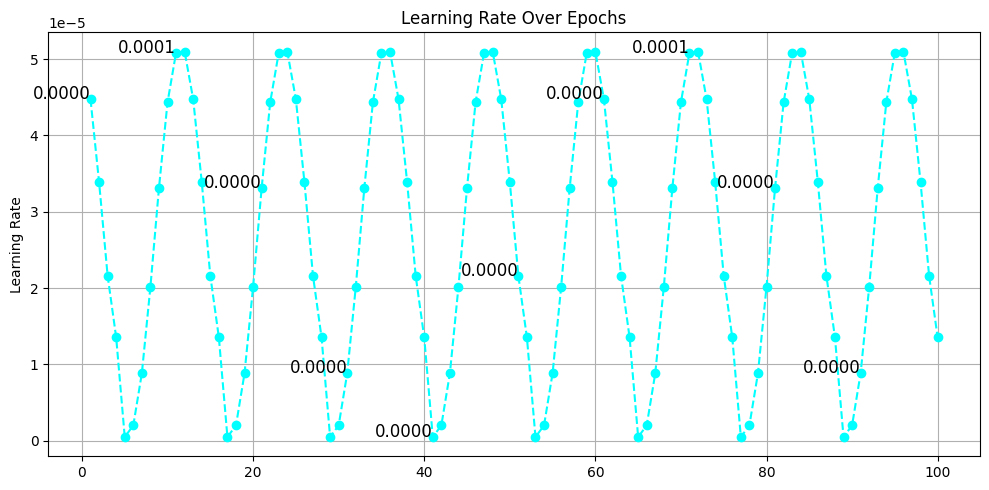

In [27]:
plot_metrics(history)

In [28]:
torch.softmax(model(gt.to(CONFIG['device']), pred.to(CONFIG['device'])), dim=1)

tensor([[0.0059, 0.3959, 0.5600, 0.0382],
        [0.0971, 0.4525, 0.3401, 0.1103],
        [0.0014, 0.2715, 0.5003, 0.2268],
        [0.0135, 0.3794, 0.5703, 0.0368],
        [0.0603, 0.3290, 0.5186, 0.0920],
        [0.0011, 0.3292, 0.4373, 0.2324],
        [0.0543, 0.4331, 0.3942, 0.1183],
        [0.0214, 0.2342, 0.5548, 0.1896],
        [0.0008, 0.1555, 0.4036, 0.4402],
        [0.1528, 0.5040, 0.2889, 0.0543],
        [0.1478, 0.3715, 0.2699, 0.2108],
        [0.0099, 0.5013, 0.4230, 0.0658],
        [0.2225, 0.4484, 0.2759, 0.0533],
        [0.0485, 0.3275, 0.3297, 0.2943],
        [0.0870, 0.5414, 0.3270, 0.0447],
        [0.1073, 0.4200, 0.3952, 0.0775]], device='mps:0',
       grad_fn=<SoftmaxBackward0>)